# **Facial Emotion Detection**


---
## **Context**
---

Deep learning has been increasingly applied to tasks involving less structured data types like images, texts, audio, and video in recent years. These endeavors often aim to achieve human-like proficiency in processing such data, leveraging our innate ability to intelligently interact with complex, unstructured information. Within the realm of AI, a field known as Artificial Emotional Intelligence, or Emotion AI, focuses on creating technologies that can understand human emotions by analyzing body language, facial expressions, and voice tones, and respond to them effectively.

Recognizing facial expressions plays a vital role in human-computer interaction. Research indicates that facial expressions and other visual signals account for about 55% of how we convey emotions. Thus, developing a model capable of accurately recognizing facial emotions is a significant stride toward equipping machines with AI that exhibits emotionally intelligent behavior. Systems that can automatically recognize facial expressions have a broad range of potential applications, from understanding human behavior to diagnosing psychological conditions, and improving the interaction quality of virtual assistants in customer service settings.

---

## **Objective**

---

The goal of this project is to use Deep Learning and Artificial Intelligence techniques to create a computer vision model that can accurately detect facial emotions. The model should be able to perform multi-class classification on images of facial expressions, to classify the expressions according to the associated emotion.

---

## **Key Questions**

---

Throughout the project, we will be answering the following questions:

- How accurately can the deep learning model identify and classify different facial emotions (happy, sad, surprise, neutral) from images?
- How well does the model generalize to new, unseen images? Can it maintain high accuracy across the test, train, and validation datasets?
- How does the different model architectures compare in terms of accuracy to classify the different emotions?
- What are the potential applications of the developed model, and what implications might its deployment have in some industry fields?

---

## **Problem Formulation**

---

We are tasked with leveraging Deep Learning techniques to develop a computer vision model capable of accurately detecting and classifying facial emotions. The model needs to distinguish between four specific emotions (happy, sad, surprise, neutral) based on images of facial expressions. This task involves multi-class classification, requiring the model to predict the correct category of emotion for each image it processes.

---

## **About the dataset**

---

The data set consists of 3 folders, i.e., 'test', 'train', and 'validation'.
Each of these folders has four subfolders:

**‘happy’**: Images of people who have happy facial expressions.<br>
**‘sad’**: Images of people with sad or upset facial expressions.<br>
**‘surprise’**: Images of people who have shocked or surprised facial expressions.<br>
**‘neutral’**: Images of people showing no prominent emotion in their facial expression at all.<br>


## **Mounting the Drive**

**NOTE:** Please use Google Colab from your browser for this notebook. **Google.colab is NOT a library that can be downloaded locally on your device.**


In [1]:
# from google.colab import drive
# drive.mount("/content/drive")

## **Importing the Libraries**


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import zipfile
import random
from PIL import Image
from typing import List
from datetime import datetime

# For Data Visualization
import seaborn as sns

# For Model Building
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential, Model  # Sequential API for sequential model
from tensorflow.keras.layers import Dense, Dropout, Flatten  # Importing different layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, LeakyReLU, ReLU
from tensorflow.keras import backend
from tensorflow.keras.optimizers import Adam  # Optimizers for optimizing the model
from tensorflow.keras.callbacks import EarlyStopping  # Regularization method to prevent the overfitting
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16
from keras.applications import VGG16
from keras.applications.resnet_v2 import preprocess_input as preprocess_input_resnetv2
from keras.applications import ResNet50V2
from keras.applications.efficientnet_v2 import preprocess_input as preprocess_input_efficientnetv2
from keras.applications import EfficientNetV2B0

2024-03-24 17:24:08.694978: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 17:24:08.694998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 17:24:08.695504: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-24 17:24:08.698689: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-24 17:24:09.229243: W tensorflow/compiler/tf2

### **Let us load and unzip the data**


**Note:**

- You must download the dataset from the link provided on Olympus and upload the same on your Google drive before executing the code in the next cell.
- In case of any error, please make sure that the path of the file is correct as the path may be different for you.


In [3]:
# Storing the path of the data file from the Google drive
# path = "/content/drive/MyDrive/Studies/MIT-AI-ML/11. Capstone Project/Facial_emotion_images.zip"

# The data is provided as a zip file so we need to extract the files from the zip file
# with zipfile.ZipFile(path, "r") as zip_ref:
#    zip_ref.extractall()

## **Preparing the Data**

The dataset has three folders, i.e., 'train', 'validation' and 'test'. Each of these folders has four sub-folders, namely 'happy', 'neutral', 'sad', and 'surprise'.

We will have the train and test path stored in a variable named 'SUBDIRS', and a base directory 'DATADIR'.

The names of the sub-folders, which will be the classes for our classification task will be stored in an array called 'CATEGORIES'.


In [4]:
DATADIR = "/home/iamtxena/sandbox/mit-ai/capstone/Facial_Emotion_Recognition/Facial_emotion_images"
# DATADIR = "/content/Facial_emotion_images"  # Base directory
SUBDIRS = ["train", "validation", "test"]  # Subdirectories
CATEGORIES = ["happy", "neutral", "sad", "surprise"]  # Emotion categories

We are going to check the size of one image, and then check if all the other images have the same size. In case, they are different, we'll resize the ones that are different.


In [5]:
def get_first_image_size(directory, sub_dirs, categories):
    """
    Returns the size of the first image found in the specified directories.

    Parameters:
    - directory (str): The base directory of the dataset.
    - sub_dirs (list of str): Subdirectories to search through (e.g., ['train', 'validation', 'test']).
    - categories (list of str): Categories (e.g., ['happy', 'neutral', 'sad', 'surprise']).

    Returns:
    - tuple: Size of the first image found (width, height).
    """
    for sub_dir in sub_dirs:
        for category in categories:
            path = os.path.join(directory, sub_dir, category)
            for img_name in os.listdir(path):
                img_path = os.path.join(path, img_name)
                with Image.open(img_path) as img:
                    return img.size  # Return the size of the first image found

In [6]:
# Get the size of the first image
expected_size = get_first_image_size(DATADIR, SUBDIRS, CATEGORIES)

print(f"Expected size of the first image: {expected_size}")

Expected size of the first image: (48, 48)


In [7]:
def check_image_sizes(directory, sub_dirs, categories, target_size):
    """
    Checks if all images in the specified directories match the target size.

    Parameters:
    - directory (str): The base directory of the dataset.
    - sub_dirs (list of str): Subdirectories to search through.
    - categories (list of str): Categories to search through.
    - target_size (tuple): The expected size of the images (width, height).

    Returns:
    - bool: True if all images match the target size, False otherwise.
    """
    all_match = True  # Flag to keep track of size match

    for sub_dir in sub_dirs:
        for category in categories:
            path = os.path.join(directory, sub_dir, category)
            for img_name in os.listdir(path):
                img_path = os.path.join(path, img_name)
                with Image.open(img_path) as img:
                    if img.size != target_size:
                        print(f"Image {img_path} has a different size: {img.size}, expected: {target_size}")
                        all_match = False
                        return all_match  # Return early upon first mismatch
    return all_match

In [8]:
# Check if all images match the expected size
all_match = check_image_sizes(DATADIR, SUBDIRS, CATEGORIES, expected_size)
if all_match:
    print("All images match the expected size.")
else:
    print("Not all images match the expected size.")

All images match the expected size.


## **Visualizing our Classes**

Let's look at our classes.

**Write down your observation for each class. What do you think can be a unique feature of each emotion, that separates it from the remaining classes?**


In [9]:
def visualize_emotion_images(directory: str, sub_dirs: List[str], emotion: str, image_count: int = 9) -> None:
    """
    Visualizes a specified number of images from a given emotion class directory across specified subdirectories.

    Parameters:
    - directory (str): The base directory where emotion class folders are located across subdirectories.
    - sub_dirs (List[str]): List of subdirectories ('train', 'validation', 'test') to search through.
    - emotion (str): The specific emotion class to visualize images from.
    - image_count (int): The number of images to display. Defaults to 9.

    Returns:
    - None: This function does not return any value but displays images inline.
    """
    image_paths: List[str] = []  # To store paths of images to be displayed

    # Iterate through the specified subdirectories to collect image paths
    for sub_dir in sub_dirs:
        emotion_dir: str = os.path.join(directory, sub_dir, emotion)
        if os.path.isdir(emotion_dir):
            for img_name in os.listdir(emotion_dir):
                img_path = os.path.join(emotion_dir, img_name)
                image_paths.append(img_path)

    # If there are no images found for the emotion, print a message and return
    if not image_paths:
        print(f"No images found for the specified emotion: {emotion}")
        return

    # Select a random subset of image paths
    selected_image_paths: np.ndarray = np.random.choice(image_paths, min(image_count, len(image_paths)), replace=False)

    # Setup for plotting
    fig = plt.figure(figsize=(4, 4))
    columns: int = 3
    rows: int = image_count // columns + (1 if image_count % columns else 0)

    # Iterate over the selected images and display them
    for i, image_path in enumerate(selected_image_paths, start=1):
        ax = fig.add_subplot(rows, columns, i)
        image = load_img(image_path, target_size=(48, 48))  # Ensure the image is resized to 48x48
        plt.imshow(image)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

### **Happy**


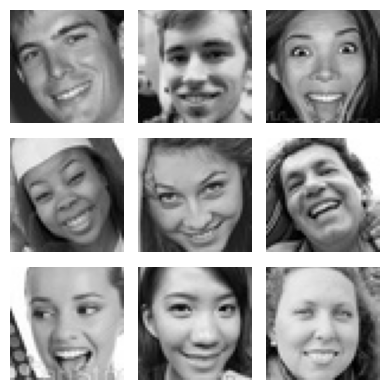

In [10]:
visualize_emotion_images(DATADIR, SUBDIRS, "happy", 9)

**Observations and Insights:**

- The images appear to be in grayscale and vary in terms of lighting, contrast, and clarity.

- The images display a range of happy expressions, from broad smiles showing teeth to subtle smiles without teeth. Also a diversity of subjects in terms of age, gender and also ethnicity.


### **Sad**


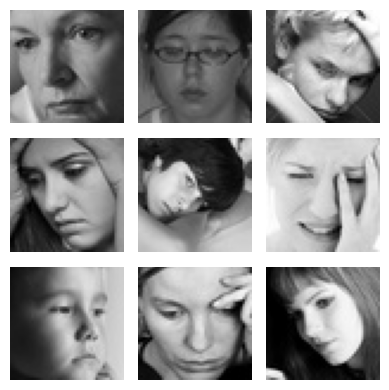

In [11]:
visualize_emotion_images(DATADIR, SUBDIRS, "sad", 9)

**Observations and Insights:**

- The images capture a wide spectrum of sadness, from subtle, somber expressions to more overt manifestations like crying.
- The dataset includes faces with different orientations and features. Some faces are directly looking at the camera, while others are tilted or partially turned away.


### **Neutral**


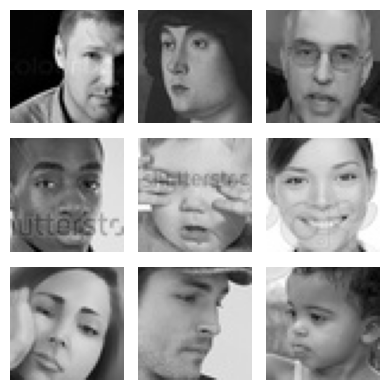

In [12]:
visualize_emotion_images(DATADIR, SUBDIRS, "neutral", 9)

**Observations and Insights:**

- The defining characteristic of these images is the absence of clear, expressive features that denote a specific emotion.
- Some faces may have subtle features that could be misconstrued as expressing a mild emotion.


### **Surprised**


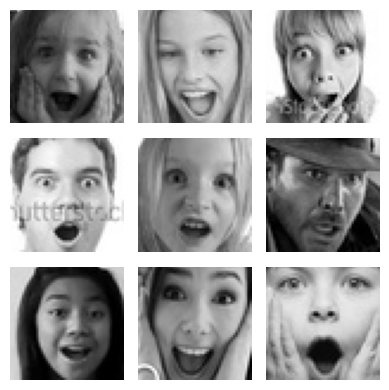

In [13]:
visualize_emotion_images(DATADIR, SUBDIRS, "surprise", 9)

**Observations and Insights:**

- The images showcase a range of intensities of surprise, from wide-eyed and open-mouthed expressions to more subdued, raised-eyebrow looks.
- The subjects vary in age, including both infants and adults.


## **Checking Distribution of Classes**


In [14]:
# Function to count images in each category
def count_images(data_dir, categories):
    counts = []
    for category in categories:
        path = os.path.join(data_dir, category)
        count = len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))])
        counts.append(count)
    return counts


SUBDIRS_DICT = {"train": "train", "validation": "validation", "test": "test"}

# Counting images in each dataset
train_counts = count_images(os.path.join(DATADIR, SUBDIRS_DICT["train"]), CATEGORIES)
validation_counts = count_images(os.path.join(DATADIR, SUBDIRS_DICT["validation"]), CATEGORIES)
test_counts = count_images(os.path.join(DATADIR, SUBDIRS_DICT["test"]), CATEGORIES)


# Create DataFrames and format for easier reading
def create_df(counts, categories, dataset_name):
    df = pd.DataFrame({"Class": categories, "Count": counts})
    df["Percentage"] = (df["Count"] / df["Count"].sum()) * 100
    df.set_index("Class", inplace=True)

    # Formatting for easier reading
    df["Count"] = df["Count"].apply(lambda x: f"{x:,}")  # Adds commas to thousands
    df["Percentage"] = df["Percentage"].apply(lambda x: f"{x:.2f}")  # Rounds to two decimals

    print(f"{dataset_name} Data Distribution:")
    print(df)
    total_images = df["Count"].str.replace(",", "").astype(int).sum()
    print(f"Total images in {dataset_name}: {total_images:,}\n")  # Formats total count with commas


create_df(train_counts, CATEGORIES, "Training")
create_df(validation_counts, CATEGORIES, "Validation")
create_df(test_counts, CATEGORIES, "Testing")

Training Data Distribution:
          Count Percentage
Class                     
happy     3,976      26.32
neutral   3,978      26.33
sad       3,982      26.36
surprise  3,173      21.00
Total images in Training: 15,109

Validation Data Distribution:
          Count Percentage
Class                     
happy     1,825      36.67
neutral   1,216      24.43
sad       1,139      22.89
surprise    797      16.01
Total images in Validation: 4,977

Testing Data Distribution:
         Count Percentage
Class                    
happy       32      25.00
neutral     32      25.00
sad         32      25.00
surprise    32      25.00
Total images in Testing: 128



**Observations and Insights:**

- Training Data: The training dataset shows a relatively balanced distribution among the classes of 'happy', 'neutral', and 'sad', each comprising approximately 26% of the dataset. However, 'surprise' is slightly underrepresented, making up 21% of the data. We'll see on the results if this is noticeable.
- Validation Data: In the validation dataset, there's a more pronounced imbalance. 'Happy' expressions dominate at 36.67%, followed by 'neutral' at 24.43%, 'sad' at 22.89%, and 'surprise' at 16.01%. This distribution deviates more significantly from an even split, indicating a potential bias towards 'happy' expressions.
- Testing Data: The testing dataset is perfectly balanced, with each class representing 25% of the data. This uniform distribution is ideal for evaluating the model's performance across all classes evenly.

Regarding the Exploratory Data Analysis, we can use data augmentation to balance the classes. For now, we'll see the results with the given dataset, and if necessary, we can adjust that.


**Think About It:**

- Are the classes equally distributed? If not, do you think the imbalance is too high? Will it be a problem as we progress?
- Are there any Exploratory Data Analysis tasks that we can do here? Would they provide any meaningful insights?


## **Creating our Data Loaders**

In this section, we are creating data loaders that we will use as inputs to our Neural Network.

**You have two options for the color_mode. You can set it to color_mode = 'rgb' or color_mode = 'grayscale'. You will need to try out both and see for yourself which one gives better performance.**


In [15]:
# Set this to 'grayscale' as the images are in grayscale
color_mode = "grayscale"

# As we have checked, all images are 48x48, we will set the img_width and img_height to 48
img_width, img_height = 48, 48
color_layers = 1
# A batch size of 32 is appropriate for this dataset provide to provide a good balance
# between the model's ability to generalize (avoid overfitting) and computational efficiency.
batch_size = 32

# Training Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values to [0,1]
    horizontal_flip=True,  # Faces are symmetric; flipping can simulate looking from another direction
    brightness_range=(0.5, 1.5),  # Randomly adjust brightness to simulate different lighting conditions
    shear_range=0.3,  # Shear transformations for perspective changes
    rotation_range=20,  # Slight rotation to introduce variability without distorting emotion features
    width_shift_range=0.1,  # Slight horizontal shifts to simulate off-center faces
    height_shift_range=0.1,  # Slight vertical shifts to account for different heights/angles
    zoom_range=0.1,  # Small zoom in/out to simulate closer or further away faces
)

# Validation and Testing Data should not be augmented!
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Assuming train_dir, validation_dir, and test_dir should follow the structure in DATADIR and SUBDIRS
train_dir = os.path.join(DATADIR, SUBDIRS_DICT["train"])
validation_dir = os.path.join(DATADIR, SUBDIRS_DICT["validation"])
test_dir = os.path.join(DATADIR, SUBDIRS_DICT["test"])

# Train Generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode=color_mode,  # Set to 'grayscale'
    class_mode="categorical",
)

# Validation Generator
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode=color_mode,  # Set to 'grayscale'
    class_mode="categorical",
    shuffle=False,  # shuffle=False to keep data in order for evaluation
)

# Testing Generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode=color_mode,  # Set to 'grayscale'
    class_mode="categorical",
    shuffle=False,  # shuffle=False to keep data in order for testing
)

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


Let's look at some examples of a batch of augmented training data.


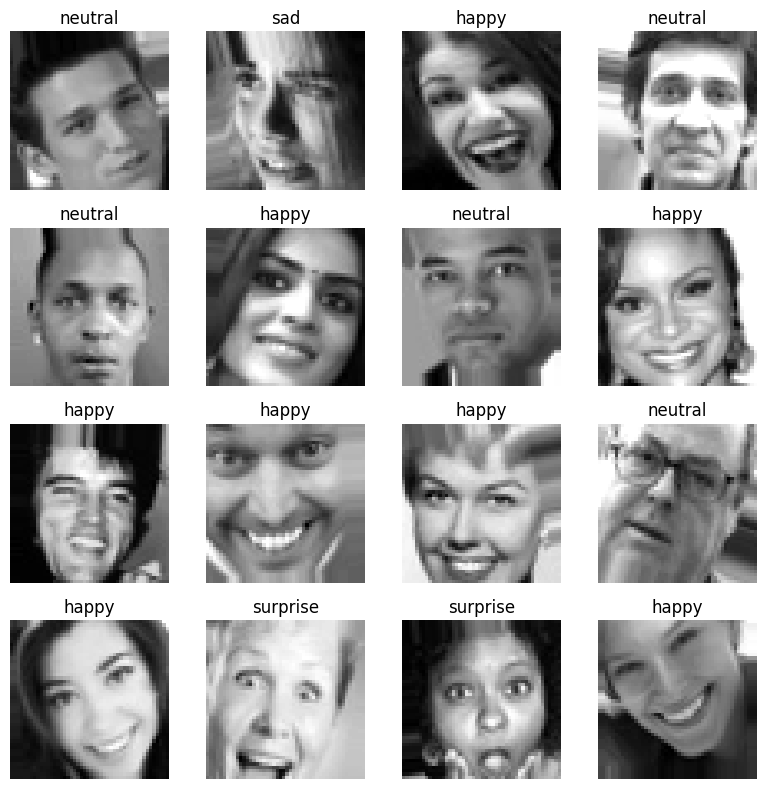

In [16]:
# Fetch a batch of images and labels
images, labels = next(train_generator)

# Assuming the labels are one-hot encoded, we need to convert them back to class indices
labels_indices = labels.argmax(axis=1)

# Mapping of indices to class names, based on the 'class_indices' attribute of the generator
index_to_class = {v: k for k, v in train_generator.class_indices.items()}

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for image, label_index, ax in zip(images, labels_indices, axes.flatten()):
    ax.imshow(image.squeeze(), cmap="gray")  # Squeeze and cmap for grayscale
    class_name = index_to_class[label_index]
    ax.set_title(class_name)
    ax.axis("off")

plt.tight_layout()
plt.show()

## **Model Building**


In [17]:
# results_path = "/content/drive/MyDrive/Studies/MIT-AI-ML/11. Capstone Project/results"
results_path = "/home/iamtxena/sandbox/mit-ai/capstone/Facial_Emotion_Recognition/results"

**Think About It:**

- Are Convolutional Neural Networks the right approach? Should we have gone with Artificial Neural Networks instead?
- What are the advantages of CNNs over ANNs and are they applicable here?


### **Creating the Base Neural Network**


### **Model 1 Architecture:**

- This is the first CNN Model, designed with a sequential architecture comprising three convolutional blocks, each followed by max-pooling and dropout layers for feature extraction and regularization.
- The **first convolutional block** starts with a **Conv2D layer having 64 filters** and a **3x3 kernel size**, utilizing **'relu' activation** and **'same' padding** to maintain the input size, paired with a **MaxPooling2D layer** with a **2x2 pool size** and **'same' padding**, and a **Dropout layer with a rate of 0.2** to prevent overfitting.
- The **second convolutional block** includes a **Conv2D layer with 32 filters**, a **3x3 kernel size**, **'relu' activation**, and **'same' padding**, followed by a **MaxPooling2D layer** with a **2x2 pool size**, **'same' padding**, and another **Dropout layer with a rate of 0.2**.
- Similarly, the **third convolutional block** mirrors the second, with a **Conv2D layer** also having **32 filters**, a **3x3 kernel size**, **'relu' activation**, and **'same' padding**, a subsequent **MaxPooling2D layer** with a **2x2 pool size**, **'same' padding**, and a **Dropout layer with a rate of 0.2**.
- After extracting features through convolutional blocks, the model **flattens** the output to feed into fully connected layers for classification.
- The **dense layers** include a **first Dense layer with 512 neurons** and **'relu' activation**, followed by a **second Dense layer with 64 neurons** and **'relu' activation**, culminating in a **final Dense layer with 4 neurons** corresponding to the number of classes, using **'softmax' activation** for multi-class classification.
- The model employs the **Adam optimizer** with a **learning rate of 0.001** to adjust weights and minimize the loss function during training.


In [18]:
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)

random.seed(42)
tf.random.set_seed(42)

In [19]:
# Intializing a sequential model
model_1 = Sequential()

model_1.add(Conv2D(64, (3, 3), activation="relu", padding="same", input_shape=(img_width, img_height, color_layers)))
model_1.add(MaxPooling2D((2, 2), padding="same"))
model_1.add(Dropout(0.2))

# Adding second conv layer with 32 filters
model_1.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model_1.add(MaxPooling2D((2, 2), padding="same"))
model_1.add(Dropout(0.2))

# Add third conv layer with 32 filters and kernel size 3x3, padding 'same' followed by a Maxpooling2D layer
model_1.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model_1.add(MaxPooling2D((2, 2), padding="same"))
model_1.add(Dropout(0.2))

# Flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model_1.add(Flatten())

# Adding Full Connected layers
model_1.add(Dense(512, activation="relu"))
model_1.add(Dense(64, activation="relu"))
model_1.add(Dense(4, activation="softmax"))

# Using Adam Optimizer
opt = Adam(learning_rate=0.001)

2024-03-24 17:24:11.552034: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-24 17:24:11.569490: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-24 17:24:11.569662: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### **Compiling and Training the Model**


In [20]:
# Compiling the model
model_1.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

# Generating the summary of the model
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 32)        0

In [21]:
class DelayedEarlyStopping(EarlyStopping):
    """Stop training when a monitored metric has stopped improving after a certain number of epochs.

    Arguments:
        monitor: Quantity to be monitored.
        min_delta: Minimum change in the monitored quantity to qualify as an improvement,
                   i.e., an absolute change of less than min_delta will count as no improvement.
        patience: Number of epochs with no improvement after which training will be stopped.
        verbose: Verbosity mode.
        mode: One of `{'auto', 'min', 'max'}`. In `min` mode, training will stop when the
              quantity monitored has stopped decreasing; in `max` mode it will stop when the
              quantity monitored has stopped increasing; in `auto` mode, the direction is
              automatically inferred from the name of the monitored quantity.
        baseline: Baseline value for the monitored quantity. Training will stop if the model
                  doesn't show improvement over the baseline.
        restore_best_weights: Whether to restore model weights from the epoch with the best value
                              of the monitored quantity.
        start_epoch: The epoch on which to start considering early stopping. Before this epoch,
                     early stopping will not be considered. This ensures that early stopping
                     checks only after a certain number of epochs.
    """

    def __init__(
        self,
        monitor="val_loss",
        min_delta=0,
        patience=0,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=False,
        start_epoch=30,
    ):
        super(DelayedEarlyStopping, self).__init__(
            monitor=monitor,
            min_delta=min_delta,
            patience=patience,
            verbose=verbose,
            mode=mode,
            baseline=baseline,
            restore_best_weights=restore_best_weights,
        )
        self.start_epoch = start_epoch

    def on_epoch_end(self, epoch, logs=None):
        # Override the original `on_epoch_end` method to include `start_epoch` logic.

        # If the current epoch is less than the start epoch, skip the early stopping check
        if epoch < self.start_epoch:
            return

        # Call the parent class method to perform the regular early stopping checks after the start epoch
        super(DelayedEarlyStopping, self).on_epoch_end(epoch, logs)


# Usage of DelayedEarlyStopping
# Define the EarlyStopping callback with a start epoch
delayed_early_stopping = DelayedEarlyStopping(
    monitor="val_loss", patience=10, verbose=1, restore_best_weights=True, start_epoch=30
)

In [22]:
# Get the current time
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")

# Set up Early Stopping with a patience 7 but acting after at least 30 epochs
delayed_early_stopping = DelayedEarlyStopping(
    monitor="val_loss", patience=7, verbose=1, restore_best_weights=True, start_epoch=30
)

# Define the learning rate scheduler callback
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=0.00001, verbose=1)
mc = ModelCheckpoint(
    f"{results_path}/best_model_1_{current_time}.keras",
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    save_best_only=True,
)

# Pulling a single large batch of random validation data for doing the validation after each epoch
validationX, validationY = validation_generator.next()

# Fitting the model with 40 epochs and using validation set
history_1 = model_1.fit(
    train_generator,
    epochs=45,
    validation_data=(validationX, validationY),
    callbacks=[reduce_lr, mc, delayed_early_stopping],
)

Epoch 1/45


2024-03-24 17:24:12.202726: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-24 17:24:12.307928: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-03-24 17:24:12.959634: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f4810d46680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-24 17:24:12.959650: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-03-24 17:24:12.964432: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1711301053.040959  231632 device_compiler.h:186] Compiled cluster using XL

469/473 [============================>.] - ETA: 0s - loss: 1.3538 - accuracy: 0.3125
Epoch 1: val_accuracy improved from -inf to 0.40625, saving model to /home/iamtxena/sandbox/mit-ai/capstone/Facial_Emotion_Recognition/results/best_model_1_20240324-172411.keras
473/473 [==============================] - 9s 13ms/step - loss: 1.3534 - accuracy: 0.3130 - val_loss: 1.2976 - val_accuracy: 0.4062 - lr: 0.0010
Epoch 2/45
469/473 [============================>.] - ETA: 0s - loss: 1.2575 - accuracy: 0.3964
Epoch 2: val_accuracy improved from 0.40625 to 0.56250, saving model to /home/iamtxena/sandbox/mit-ai/capstone/Facial_Emotion_Recognition/results/best_model_1_20240324-172411.keras
473/473 [==============================] - 6s 12ms/step - loss: 1.2572 - accuracy: 0.3967 - val_loss: 1.2069 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 3/45
472/473 [============================>.] - ETA: 0s - loss: 1.1952 - accuracy: 0.4441
Epoch 3: val_accuracy did not improve from 0.56250
473/473 [==============

### **Plotting the Training and Validation Accuracies**


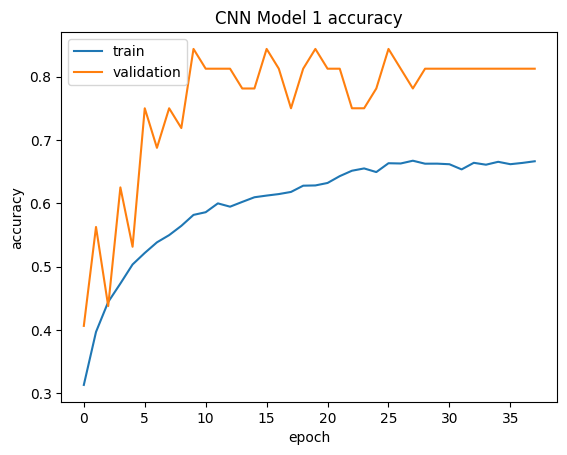

In [23]:
plt.plot(history_1.history["accuracy"])
plt.plot(history_1.history["val_accuracy"])
plt.title("CNN Model 1 accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

### **Evaluating the Model on the Test Set**


In [24]:
# Calculate the number of steps for the entire test set to be processed
test_steps = test_generator.samples // batch_size

# If the number of samples isn't a multiple of the batch size,
# you have one more batch with the remaining samples
if test_generator.samples % batch_size > 0:
    test_steps += 1

# Evaluating the model on the test set
evaluation_results = model_1.evaluate(test_generator, steps=test_steps)
print(f"Loss: {evaluation_results[0]}, Accuracy: {evaluation_results[1]}")

4/4 [==============================] - 0s 4ms/step - loss: 0.6298 - accuracy: 0.7109
Loss: 0.6297590732574463, Accuracy: 0.7109375


### **Plotting Confusion Matrix**


4/4 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

       happy       0.87      0.81      0.84        32
     neutral       0.57      0.66      0.61        32
         sad       0.55      0.53      0.54        32
    surprise       0.90      0.84      0.87        32

    accuracy                           0.71       128
   macro avg       0.72      0.71      0.71       128
weighted avg       0.72      0.71      0.71       128



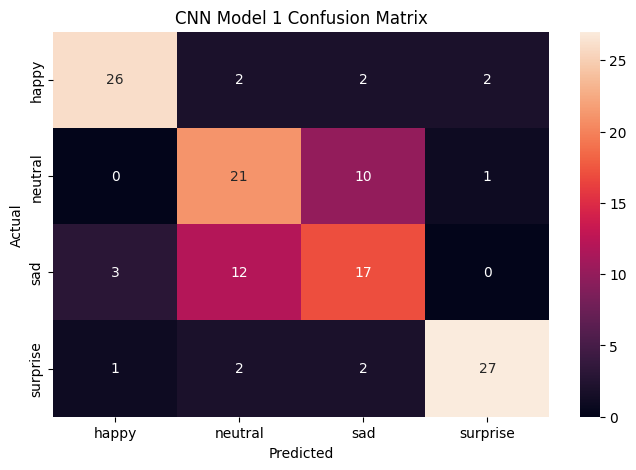

In [25]:
pred_probabilities = model_1.predict(test_generator, steps=test_steps)
pred = np.argmax(pred_probabilities, axis=1)

# Getting the true labels from the generator
y_true = test_generator.classes

# Printing the classification report with actual emotion labels
print(classification_report(y_true, pred, target_names=CATEGORIES))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt=".0f", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("CNN Model 1 Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

**Observations and Insights:**

- The CNN model is designed with a total of **651,780 trainable parameters**.
- The training process reveals that the model's accuracy on the training set increases gradually, achieving a final accuracy of **68.01%**. The validation accuracy exhibits significant improvement over the training accuracy, with a peak of **87.50%**, indicating that the model may have learned features that generalize well to unseen data.
- The evaluation on the test set results in an accuracy of **74.22%**, which suggests that the model is capable of predicting unseen data with a reasonable level of accuracy.
- Analyzing the confusion matrix, we find that the model is most effective at recognizing 'happy' and 'surprise' emotions with an f1-score of **0.87** for both classes. 'Neutral' and 'sad' emotions present more of a challenge for the model with lower f1-scores of **0.64** and **0.60** respectively. This disparity suggests that the model may benefit from more varied training data or different network architectures to improve its ability to distinguish these emotions.
- True Positive Rates: 'happy' at 90%, 'surprise' at 90%, 'neutral' at 57%, and 'sad' at 64%.
- The model tends to predict 'neutral' and 'sad' with less precision and recall, indicating potential areas for improvement.


### **Creating the second Convolutional Neural Network**


### **Model 2 Architecture:**

- This model is designed with a sequential structure, incorporating four convolutional blocks for feature extraction, followed by dense layers for classification.
- **First Convolutional Block:**

  - Begins with a **Conv2D layer** with **256 filters**, a **2x2 kernel size**, **'same' padding**, and an input shape of **(48, 48, 1)**, indicating grayscale images of size 48x48.
  - Includes **BatchNormalization** to stabilize and speed up training.
  - Utilizes **LeakyReLU** with an alpha of **0.1** for activation, allowing a small gradient when the unit is not active.
  - Applies **MaxPooling2D** with a **pool size of 2** to reduce spatial dimensions.

- **Second Convolutional Block:**

  - Consists of a **Conv2D layer** with **128 filters** and a **2x2 kernel size**, using **'same' padding**.
  - Follows the same pattern of **BatchNormalization**, **LeakyReLU** activation, and **MaxPooling2D**.

- **Third Convolutional Block:**

  - Features a **Conv2D layer** with **64 filters** and a **2x2 kernel size**, maintaining **'same' padding**.
  - Repeats the **BatchNormalization**, **LeakyReLU** activation, and **MaxPooling2D** structure.

- **Fourth Convolutional Block:**

  - Contains a **Conv2D layer** with **32 filters** and a **2x2 kernel size**, with **'same' padding**.
  - Continues with **BatchNormalization**, **LeakyReLU** activation, and **MaxPooling2D**.

- After processing through the convolutional blocks, the model **flattens** the output to transition to fully connected layers.
- **Fully Connected Dense Layers:**
  - Incorporates a dense layer with **512 neurons** and **'relu' activation**.
  - Followed by a dense layer with **128 neurons** and **'relu' activation**.
  - Then, a dense layer with **64 neurons** without an explicit activation is added before **BatchNormalization** and **ReLU** activation to introduce non-linearity.
- **Output Layer:**
  - Concludes with a **Dense layer** having **4 neurons** and **'softmax' activation** for multi-class classification of 4 emotions.
- The model employs the **Adam optimizer** with a **learning rate of 0.001**, optimizing the categorical crossentropy loss function for training.


In [26]:
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)

random.seed(42)
tf.random.set_seed(42)

In [27]:
# Initializing a sequential model
model_2 = Sequential()

# First Convolutional Block
model_2.add(Conv2D(256, kernel_size=2, padding="same", input_shape=(48, 48, 1)))
model_2.add(BatchNormalization())
model_2.add(LeakyReLU(alpha=0.1))
model_2.add(MaxPooling2D(pool_size=2))

# Second Convolutional Block
model_2.add(Conv2D(128, kernel_size=2, padding="same"))
model_2.add(BatchNormalization())
model_2.add(LeakyReLU(alpha=0.1))
model_2.add(MaxPooling2D(pool_size=2))

# Third Convolutional Block
model_2.add(Conv2D(64, kernel_size=2, padding="same"))
model_2.add(BatchNormalization())
model_2.add(LeakyReLU(alpha=0.1))
model_2.add(MaxPooling2D(pool_size=2))

# Fourth Convolutional Block
model_2.add(Conv2D(32, kernel_size=2, padding="same"))
model_2.add(BatchNormalization())
model_2.add(LeakyReLU(alpha=0.1))
model_2.add(MaxPooling2D(pool_size=2))

# Flatten the output of the conv layers to feed into the dense layers
model_2.add(Flatten())

# Fully connected layers
model_2.add(Dense(512, activation="relu"))
model_2.add(Dense(128, activation="relu"))
model_2.add(Dense(64))
model_2.add(BatchNormalization())
model_2.add(ReLU())  # Using ReLU after batch normalization
model_2.add(Dense(4, activation="softmax"))

# Using Adam Optimizer
optimizer = Adam(learning_rate=0.001)

### **Compiling and Training the Model**


In [28]:
# Compile the model
model_2.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 256)       1280      
                                                                 
 batch_normalization (Batch  (None, 48, 48, 256)       1024      
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 48, 48, 256)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 256)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       131200    
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 128)       5

In [29]:
# Get the current time
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")

# Set up Early Stopping with a patience 7 but acting after at least 30 epochs
delayed_early_stopping = DelayedEarlyStopping(
    monitor="val_loss", patience=7, verbose=1, restore_best_weights=True, start_epoch=30
)

# Define the learning rate scheduler callback
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=0.00001, verbose=1)

mc = ModelCheckpoint(
    f"{results_path}/best_model_2_{current_time}.keras",
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    save_best_only=True,
)

# Pulling a single large batch of random validation data for doing the validation after each epoch
validationX, validationY = validation_generator.next()

# Fitting the model with 40 epochs and using validation set
history_2 = model_2.fit(
    train_generator,
    epochs=45,
    validation_data=(validationX, validationY),
    callbacks=[reduce_lr, mc, delayed_early_stopping],
)

Epoch 1/45
471/473 [============================>.] - ETA: 0s - loss: 1.2799 - accuracy: 0.3947
Epoch 1: val_accuracy improved from -inf to 0.87500, saving model to /home/iamtxena/sandbox/mit-ai/capstone/Facial_Emotion_Recognition/results/best_model_2_20240324-172751.keras
473/473 [==============================] - 10s 14ms/step - loss: 1.2805 - accuracy: 0.3943 - val_loss: 0.8329 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 2/45
469/473 [============================>.] - ETA: 0s - loss: 1.1031 - accuracy: 0.5060
Epoch 2: val_accuracy did not improve from 0.87500
473/473 [==============================] - 6s 12ms/step - loss: 1.1023 - accuracy: 0.5063 - val_loss: 2.4464 - val_accuracy: 0.1562 - lr: 0.0010
Epoch 3/45
473/473 [==============================] - ETA: 0s - loss: 0.9986 - accuracy: 0.5675
Epoch 3: val_accuracy did not improve from 0.87500
473/473 [==============================] - 6s 12ms/step - loss: 0.9986 - accuracy: 0.5675 - val_loss: 1.1561 - val_accuracy: 0.5000 - lr: 0.0

### **Plotting the Training and Validation Accuracies**


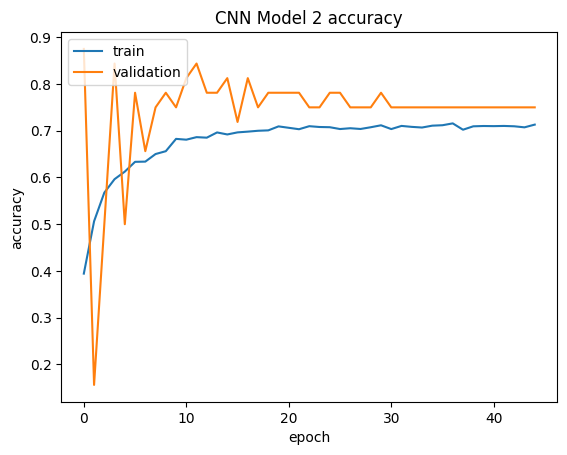

In [30]:
plt.plot(history_2.history["accuracy"])
plt.plot(history_2.history["val_accuracy"])
plt.title("CNN Model 2 accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

### **Evaluating the Model on the Test Set**


In [31]:
# Calculate the number of steps for the entire test set to be processed
test_steps = test_generator.samples // batch_size

# If the number of samples isn't a multiple of the batch size,
# you have one more batch with the remaining samples
if test_generator.samples % batch_size > 0:
    test_steps += 1

# Evaluating the model on the test set
evaluation_results = model_2.evaluate(test_generator, steps=test_steps)
print(f"Loss: {evaluation_results[0]}, Accuracy: {evaluation_results[1]}")

4/4 [==============================] - 0s 5ms/step - loss: 0.5349 - accuracy: 0.8125
Loss: 0.5349372029304504, Accuracy: 0.8125


### **Plotting Confusion Matrix**


4/4 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

       happy       0.83      0.91      0.87        32
     neutral       0.71      0.78      0.75        32
         sad       0.76      0.69      0.72        32
    surprise       0.97      0.88      0.92        32

    accuracy                           0.81       128
   macro avg       0.82      0.81      0.81       128
weighted avg       0.82      0.81      0.81       128



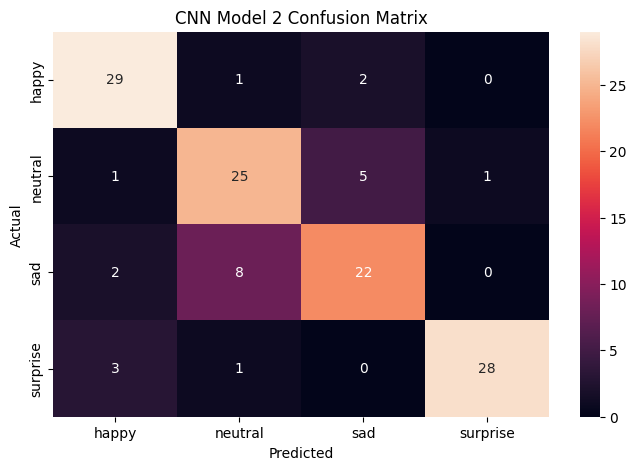

In [32]:
pred_probabilities = model_2.predict(test_generator, steps=test_steps)
pred = np.argmax(pred_probabilities, axis=1)

# Getting the true labels from the generator
y_true = test_generator.classes

# Printing the classification report with actual emotion labels
print(classification_report(y_true, pred, target_names=CATEGORIES))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt=".0f", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("CNN Model 2 Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

**Observations and Insights:**

- The model's **total parameters are 397,860**, which includes **396,772 trainable parameters**.
- An observed training accuracy of approximately **72.22%** shows competence in learning from the training data. In contrast, a validation accuracy of **59.38%** at the end of the training cycle indicates underperformance on the validation set, hinting at potential overfitting or a lack of generalizability.
- The test set evaluation yielded an accuracy of **78.12%**, which is a positive indication of the model's ability to generalize well, despite the previously mentioned validation underperformance.
- Notably, the model has demonstrated considerable precision in identifying the 'surprise' emotion, with a **precision of 97%** and a **recall of 88%**. The 'happy' emotion also reflects strong recognition capabilities with a **precision of 90%**. Conversely, the model shows lower precision and recall for the 'neutral' and 'sad' emotions, suggesting these are areas where the model's discernment could be enhanced.
- When compared with the first CNN model, this second iteration exhibits improved scores in precision, recall, and f1-score.


## **Think About It:**

- Did the models have a satisfactory performance? If not, then what are the possible reasons?
- Which Color mode showed better overall performance? What are the possible reasons? Do you think having 'rgb' color mode is needed because the images are already black and white?


## **Transfer Learning Architectures**

In this section, we will create several Transfer Learning architectures. For the pre-trained models, we will select three popular architectures namely, VGG16, ResNet v2, and Efficient Net. The difference between these architectures and the previous architectures is that these will require 3 input channels while the earlier ones worked on 'grayscale' images. Therefore, we need to create new DataLoaders.


### **Creating our Data Loaders for Transfer Learning Architectures**

In this section, we are creating data loaders that we will use as inputs to our Neural Network. We will have to go with color_mode = 'rgb' as this is the required format for the transfer learning architectures.


In [33]:
# Set this to 'rgb' as this is the required format for the transfer learning architectures
color_mode = "rgb"
color_layers = 3
# Resize our images to the same size expected by the transfer learning architectures
# img_width, img_height = 224, 224
img_width, img_height = 48, 48
# A batch size of 32 is appropriate for this dataset provide to provide a good balance
# between the model's ability to generalize (avoid overfitting) and computational efficiency.
batch_size = 32

# Training Data Augmentation
train_datagen_vgg16 = ImageDataGenerator(
    preprocessing_function=preprocess_input_vgg16,  # Use model-specific preprocessing
    horizontal_flip=True,  # Faces are symmetric; flipping can simulate looking from another direction
    brightness_range=(0.5, 1.5),  # Randomly adjust brightness to simulate different lighting conditions
    shear_range=0.3,  # Shear transformations for perspective changes
    rotation_range=20,  # Slight rotation to introduce variability without distorting emotion features
    width_shift_range=0.1,  # Slight horizontal shifts to simulate off-center faces
    height_shift_range=0.1,  # Slight vertical shifts to account for different heights/angles
    zoom_range=0.1,  # Small zoom in/out to simulate closer or further away faces
)

# Training Data Augmentation
train_datagen_resnet = ImageDataGenerator(
    preprocessing_function=preprocess_input_resnetv2,  # Use model-specific preprocessing
    horizontal_flip=True,  # Faces are symmetric; flipping can simulate looking from another direction
    brightness_range=(0.5, 1.5),  # Randomly adjust brightness to simulate different lighting conditions
    shear_range=0.3,  # Shear transformations for perspective changes
    rotation_range=20,  # Slight rotation to introduce variability without distorting emotion features
    width_shift_range=0.1,  # Slight horizontal shifts to simulate off-center faces
    height_shift_range=0.1,  # Slight vertical shifts to account for different heights/angles
    zoom_range=0.1,  # Small zoom in/out to simulate closer or further away faces
)

# Training Data Augmentation
train_datagen_efficientnet = ImageDataGenerator(
    preprocessing_function=preprocess_input_efficientnetv2,  # Use model-specific preprocessing
    horizontal_flip=True,  # Faces are symmetric; flipping can simulate looking from another direction
    brightness_range=(0.5, 1.5),  # Randomly adjust brightness to simulate different lighting conditions
    shear_range=0.3,  # Shear transformations for perspective changes
    rotation_range=20,  # Slight rotation to introduce variability without distorting emotion features
    width_shift_range=0.1,  # Slight horizontal shifts to simulate off-center faces
    height_shift_range=0.1,  # Slight vertical shifts to account for different heights/angles
    zoom_range=0.1,  # Small zoom in/out to simulate closer or further away faces
)

# Validation and Testing Data should not be augmented! VGG16 version
validation_datagen_vgg16 = ImageDataGenerator(
    preprocessing_function=preprocess_input_vgg16
)  # Use model-specific preprocessing
test_datagen_vgg16 = ImageDataGenerator(
    preprocessing_function=preprocess_input_vgg16
)  # Use model-specific preprocessing

# Validation and Testing Data should not be augmented! ResNet version
validation_datagen_resnet = ImageDataGenerator(
    preprocessing_function=preprocess_input_resnetv2
)  # Use model-specific preprocessing
test_datagen_resnet = ImageDataGenerator(
    preprocessing_function=preprocess_input_resnetv2
)  # Use model-specific preprocessing

# Validation and Testing Data should not be augmented! Efficient Net version
validation_datagen_efficientnet = ImageDataGenerator(
    preprocessing_function=preprocess_input_efficientnetv2
)  # Use model-specific preprocessing
test_datagen_efficientnet = ImageDataGenerator(
    preprocessing_function=preprocess_input_efficientnetv2
)  # Use model-specific preprocessing


# Assuming train_dir, validation_dir, and test_dir should follow the structure in DATADIR and SUBDIRS
train_dir = os.path.join(DATADIR, SUBDIRS_DICT["train"])
validation_dir = os.path.join(DATADIR, SUBDIRS_DICT["validation"])
test_dir = os.path.join(DATADIR, SUBDIRS_DICT["test"])

# Train Generator VGG16
train_generator_vgg16 = train_datagen_vgg16.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode=color_mode,
    class_mode="categorical",
)

# Train Generator ResNet
train_generator_resnet = train_datagen_resnet.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode=color_mode,
    class_mode="categorical",
)

# Train Generator EfficientNet
train_generator_efficientnet = train_datagen_efficientnet.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode=color_mode,
    class_mode="categorical",
)

# Validation Generator VGG16
validation_generator_vgg16 = validation_datagen_vgg16.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode=color_mode,
    class_mode="categorical",
    shuffle=False,  # shuffle=False to keep data in order for evaluation
)

# Validation Generator ResNet
validation_generator_resnet = validation_datagen_resnet.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode=color_mode,
    class_mode="categorical",
    shuffle=False,  # shuffle=False to keep data in order for evaluation
)

# Validation Generator EfficientNet
validation_generator_efficientnet = validation_datagen_efficientnet.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode=color_mode,
    class_mode="categorical",
    shuffle=False,  # shuffle=False to keep data in order for evaluation
)

# Testing Generator VGG16
test_generator_vgg16 = test_datagen_vgg16.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode=color_mode,
    class_mode="categorical",
    shuffle=False,  # shuffle=False to keep data in order for testing
)

# Testing Generator ResNet
test_generator_resnet = test_datagen_resnet.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode=color_mode,
    class_mode="categorical",
    shuffle=False,  # shuffle=False to keep data in order for testing
)

# Testing Generator EfficientNet
test_generator_efficientnet = test_datagen_efficientnet.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode=color_mode,
    class_mode="categorical",
    shuffle=False,  # shuffle=False to keep data in order for testing
)

Found 15109 images belonging to 4 classes.
Found 15109 images belonging to 4 classes.
Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.
Found 128 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


## **VGG16 Model**


### **Importing the VGG16 Architecture**


In [34]:
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)

random.seed(42)
tf.random.set_seed(42)

In [35]:
vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(img_width, img_height, color_layers))
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

### **Model Building**

- Import VGG16 upto the layer of your choice and add Fully Connected layers on top of it.


In [36]:
# Define a new model that cuts VGG16 at the 'block3_pool' layer
model_output = vgg_model.get_layer("block3_pool").output
cut_model = Model(inputs=vgg_model.input, outputs=model_output)

for layer in vgg_model.layers:
    layer.trainable = False

In [37]:
new_vgg16_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
new_vgg16_model.add(cut_model)

# Reduces each feature map to a single value by averaging all elements
new_vgg16_model.add(GlobalAveragePooling2D())

# Adding a dense output layer
new_vgg16_model.add(Dense(512, activation="relu"))
new_vgg16_model.add(Dense(128, activation="relu"))
new_vgg16_model.add(Dense(64))
new_vgg16_model.add(BatchNormalization())
new_vgg16_model.add(ReLU())  # Using ReLU after batch normalization
new_vgg16_model.add(Dense(4, activation="softmax"))

# Using Adam Optimizer
optimizer = Adam(learning_rate=0.001)

### **Compiling and Training the VGG16 Model**


In [38]:
new_vgg16_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
new_vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 6, 6, 256)         1735488   
                                                                 
 global_average_pooling2d (  (None, 256)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               131584    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                         

In [39]:
# Get the current time
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")

# Set up Early Stopping with a patience 7 but acting after at least 20 epochs
delayed_early_stopping = DelayedEarlyStopping(
    monitor="val_loss", patience=7, verbose=1, restore_best_weights=True, start_epoch=20
)

# Define the learning rate scheduler callback
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=0.00001, verbose=1)

mc = ModelCheckpoint(
    f"{results_path}/best_model_vgg16_{current_time}.keras",
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    save_best_only=True,
)

# Pulling a single large batch of random validation data for doing the validation after each epoch
validationX, validationY = validation_generator_vgg16.next()

# Fitting the model with 40 epochs and using validation set
history_vgg = new_vgg16_model.fit(
    train_generator_vgg16,
    epochs=40,
    validation_data=(validationX, validationY),
    callbacks=[reduce_lr, mc, delayed_early_stopping],
)

Epoch 1/40
472/473 [============================>.] - ETA: 0s - loss: 1.1633 - accuracy: 0.4821
Epoch 1: val_accuracy improved from -inf to 0.18750, saving model to /home/iamtxena/sandbox/mit-ai/capstone/Facial_Emotion_Recognition/results/best_model_vgg16_20240324-173216.keras
473/473 [==============================] - 11s 21ms/step - loss: 1.1635 - accuracy: 0.4821 - val_loss: 1.9582 - val_accuracy: 0.1875 - lr: 0.0010
Epoch 2/40
471/473 [============================>.] - ETA: 0s - loss: 1.0728 - accuracy: 0.5410
Epoch 2: val_accuracy improved from 0.18750 to 0.65625, saving model to /home/iamtxena/sandbox/mit-ai/capstone/Facial_Emotion_Recognition/results/best_model_vgg16_20240324-173216.keras
473/473 [==============================] - 10s 21ms/step - loss: 1.0726 - accuracy: 0.5409 - val_loss: 1.0014 - val_accuracy: 0.6562 - lr: 0.0010
Epoch 3/40
473/473 [==============================] - ETA: 0s - loss: 1.0416 - accuracy: 0.5544
Epoch 3: val_accuracy improved from 0.65625 to 0.7812

### **Plotting the Training and Validation Accuracies**


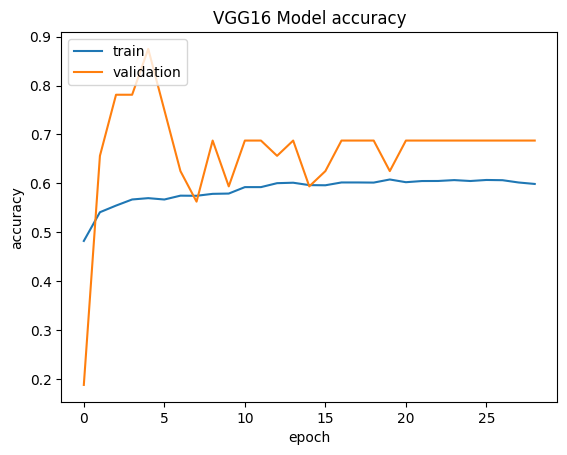

In [40]:
plt.plot(history_vgg.history["accuracy"])
plt.plot(history_vgg.history["val_accuracy"])
plt.title("VGG16 Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

### **Evaluating the VGG16 model**


In [41]:
# Calculate the number of steps for the entire test set to be processed
test_steps = test_generator_vgg16.samples // batch_size

# If the number of samples isn't a multiple of the batch size,
# you have one more batch with the remaining samples
if test_generator.samples % batch_size > 0:
    test_steps += 1

# Evaluating the model on the test set
evaluation_results = new_vgg16_model.evaluate(test_generator_vgg16, steps=test_steps)
print(f"Loss: {evaluation_results[0]}, Accuracy: {evaluation_results[1]}")

4/4 [==============================] - 0s 6ms/step - loss: 0.8646 - accuracy: 0.6094
Loss: 0.8646227717399597, Accuracy: 0.609375


### **Plotting Confusion Matrix**


4/4 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

       happy       0.57      0.72      0.64        32
     neutral       0.48      0.50      0.49        32
         sad       0.61      0.44      0.51        32
    surprise       0.78      0.78      0.78        32

    accuracy                           0.61       128
   macro avg       0.61      0.61      0.61       128
weighted avg       0.61      0.61      0.61       128



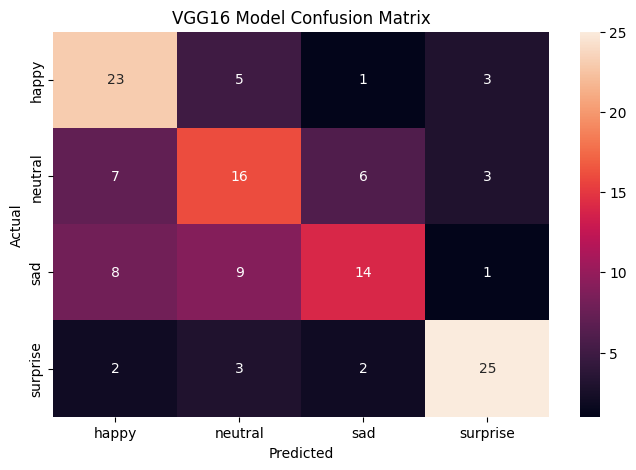

In [42]:
pred_probabilities = new_vgg16_model.predict(test_generator_vgg16, steps=test_steps)
pred = np.argmax(pred_probabilities, axis=1)

# Getting the true labels from the generator
y_true = test_generator_vgg16.classes

# Printing the classification report with actual emotion labels
print(classification_report(y_true, pred, target_names=CATEGORIES))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt=".0f", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("VGG16 Model Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

**Think About It:**

- What do you infer from the general trend in the training performance?
- Is the training accuracy consistently improving?
- Is the validation accuracy also improving similarly?


**Observations and Insights:\_\_**


**Note: You can even go back and build your own architecture on top of the VGG16 Transfer layer and see if you can improve the performance**


## **ResNet V2 Model**


I chose ResNet50V2 over other ResNetV2 models for classifying facial emotions in 48x48 grayscale images because its shallower architecture provides a good balance between computational efficiency and the ability to capture relevant features without overfitting, making it particularly suitable for our dataset's modest complexity and size.


In [43]:
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)

random.seed(42)
tf.random.set_seed(42)

In [44]:
resnet_model = ResNet50V2(weights="imagenet", include_top=False, input_shape=(img_width, img_height, color_layers))
resnet_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 54, 54, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 24, 24, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 26, 26, 64)           0         ['conv1_conv[0][0]']          
                                                                                         

### **Model Building**

- Import Resnet v2 upto the layer of your choice and add Fully Connected layers on top of it.


In [45]:
# Define a new model that cuts ResNet50V2 at the 'conv3_block4_out' layer
model_output = resnet_model.get_layer("conv3_block4_out").output
cut_model = Model(inputs=resnet_model.input, outputs=model_output)

for layer in resnet_model.layers:
    layer.trainable = False

In [46]:
new_resnet_model = Sequential()
new_resnet_model.add(resnet_model)

# Reduces each feature map to a single value by averaging all elements
new_resnet_model.add(GlobalAveragePooling2D())

# Adding a dense output layer
new_resnet_model.add(Dense(512, activation="relu"))
new_resnet_model.add(Dense(128, activation="relu"))
new_resnet_model.add(Dense(64))
new_resnet_model.add(BatchNormalization())
new_resnet_model.add(ReLU())  # Using ReLU after batch normalization
new_resnet_model.add(Dense(4, activation="softmax"))

# Using Adam Optimizer
optimizer = Adam(learning_rate=0.001)

### **Compiling and Training the Model**


In [47]:
new_resnet_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
new_resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                         

In [48]:
# Get the current time
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")

# Set up Early Stopping with a patience 7 but acting after at least 20 epochs
delayed_early_stopping = DelayedEarlyStopping(
    monitor="val_loss", patience=7, verbose=1, restore_best_weights=True, start_epoch=20
)

# Define the learning rate scheduler callback
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=0.00001, verbose=1)

mc = ModelCheckpoint(
    f"{results_path}/best_model_resnet_{current_time}.keras",
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    save_best_only=True,
)

# Pulling a single large batch of random validation data for doing the validation after each epoch
validationX, validationY = validation_generator_resnet.next()

# Fitting the model with 40 epochs and using validation set
history_resnet = new_resnet_model.fit(
    train_generator_resnet,
    epochs=40,
    validation_data=(validationX, validationY),
    callbacks=[reduce_lr, mc, delayed_early_stopping],
)

Epoch 1/40
471/473 [============================>.] - ETA: 0s - loss: 1.2166 - accuracy: 0.4574
Epoch 1: val_accuracy improved from -inf to 0.40625, saving model to /home/iamtxena/sandbox/mit-ai/capstone/Facial_Emotion_Recognition/results/best_model_resnet_20240324-173704.keras
473/473 [==============================] - 13s 23ms/step - loss: 1.2163 - accuracy: 0.4574 - val_loss: 1.3634 - val_accuracy: 0.4062 - lr: 0.0010
Epoch 2/40
472/473 [============================>.] - ETA: 0s - loss: 1.1494 - accuracy: 0.4965
Epoch 2: val_accuracy did not improve from 0.40625
473/473 [==============================] - 10s 21ms/step - loss: 1.1494 - accuracy: 0.4966 - val_loss: 1.5095 - val_accuracy: 0.4062 - lr: 0.0010
Epoch 3/40
472/473 [============================>.] - ETA: 0s - loss: 1.1351 - accuracy: 0.5067
Epoch 3: val_accuracy improved from 0.40625 to 0.50000, saving model to /home/iamtxena/sandbox/mit-ai/capstone/Facial_Emotion_Recognition/results/best_model_resnet_20240324-173704.keras


### **Plotting the Training and Validation Accuracies**


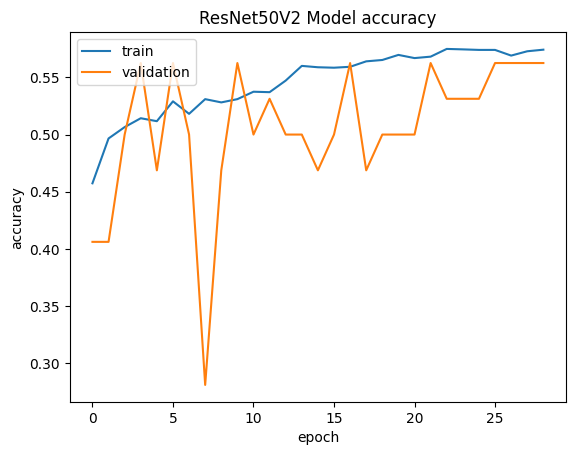

In [49]:
plt.plot(history_resnet.history["accuracy"])
plt.plot(history_resnet.history["val_accuracy"])
plt.title("ResNet50V2 Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

### **Evaluating the ResNet Model**


In [50]:
# Calculate the number of steps for the entire test set to be processed
test_steps = test_generator_resnet.samples // batch_size

# If the number of samples isn't a multiple of the batch size,
# you have one more batch with the remaining samples
if test_generator_resnet.samples % batch_size > 0:
    test_steps += 1

# Evaluating the model on the test set
evaluation_results = new_resnet_model.evaluate(test_generator_resnet, steps=test_steps)
print(f"Loss: {evaluation_results[0]}, Accuracy: {evaluation_results[1]}")

4/4 [==============================] - 0s 6ms/step - loss: 1.0132 - accuracy: 0.5703
Loss: 1.0131906270980835, Accuracy: 0.5703125


### **Plotting Confusion Matrix**


4/4 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

       happy       0.62      0.78      0.69        32
     neutral       0.37      0.41      0.39        32
         sad       0.63      0.38      0.47        32
    surprise       0.68      0.72      0.70        32

    accuracy                           0.57       128
   macro avg       0.58      0.57      0.56       128
weighted avg       0.58      0.57      0.56       128



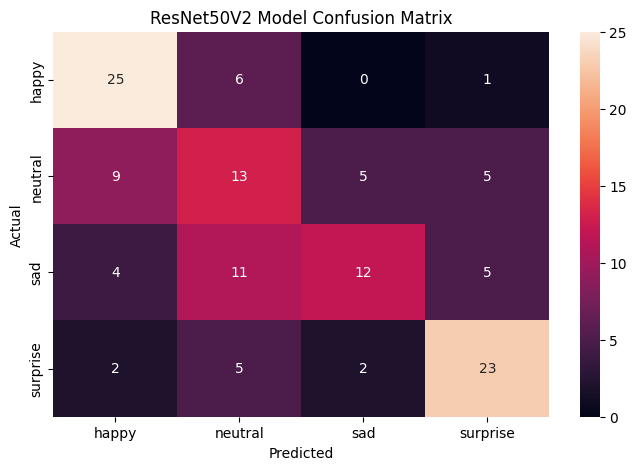

In [51]:
pred_probabilities = new_resnet_model.predict(test_generator_resnet, steps=test_steps)
pred = np.argmax(pred_probabilities, axis=1)

# Getting the true labels from the generator
y_true = test_generator_resnet.classes

# Printing the classification report with actual emotion labels
print(classification_report(y_true, pred, target_names=CATEGORIES))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt=".0f", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("ResNet50V2 Model Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

**Observations and Insights:\_\_**

**Note: You can even go back and build your own architecture on top of the ResNet Transfer layer and see if you can improve the performance.**


## **EfficientNet Model**


In [52]:
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)

random.seed(42)
tf.random.set_seed(42)

In [53]:
efficient_model = EfficientNetV2B0(
    weights="imagenet", include_top=False, input_shape=(img_width, img_height, color_layers)
)
# Making all the layers of the efficient_model model non-trainable. i.e. freezing them
for layer in efficient_model.layers:
    layer.trainable = False

efficient_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 48, 48, 3)            0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 48, 48, 3)            0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 24, 24, 32)           864       ['normalizatio

### **Model Building**

- Import EfficientNet upto the layer of your choice and add Fully Connected layers on top of it.


In [54]:
new_efficient_model = Sequential()
new_efficient_model.add(efficient_model)

# Reduces each feature map to a single value by averaging all elements
new_efficient_model.add(GlobalAveragePooling2D())

# Adding a dense output layer
new_efficient_model.add(Dense(512, activation="relu"))
new_efficient_model.add(Dense(128, activation="relu"))
new_efficient_model.add(Dense(64))
new_efficient_model.add(BatchNormalization())
new_efficient_model.add(ReLU())  # Using ReLU after batch normalization
new_efficient_model.add(Dense(4, activation="softmax"))

# Using Adam Optimizer
optimizer = Adam(learning_rate=0.001)

### **Compiling and Training the Model**


In [55]:
new_efficient_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
new_efficient_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Functio  (None, 2, 2, 1280)        5919312   
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization (Batch  (None, 64)                2

In [56]:
# Get the current time
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")

# Set up Early Stopping with a patience 7 but acting after at least 20 epochs
delayed_early_stopping = DelayedEarlyStopping(
    monitor="val_loss", patience=7, verbose=1, restore_best_weights=True, start_epoch=20
)

# Define the learning rate scheduler callback
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=0.00001, verbose=1)

mc = ModelCheckpoint(
    f"{results_path}/best_model_efficient_{current_time}.keras",
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    save_best_only=True,
)

# Pulling a single large batch of random validation data for doing the validation after each epoch
validationX, validationY = validation_generator_efficientnet.next()

# Fitting the model with 40 epochs and using validation set
history_efficient = new_efficient_model.fit(
    train_generator_efficientnet,
    epochs=40,
    validation_data=(validationX, validationY),
    callbacks=[reduce_lr, mc, delayed_early_stopping],
)

Epoch 1/40
471/473 [============================>.] - ETA: 0s - loss: 1.1934 - accuracy: 0.4790
Epoch 1: val_accuracy improved from -inf to 0.71875, saving model to /home/iamtxena/sandbox/mit-ai/capstone/Facial_Emotion_Recognition/results/best_model_efficient_20240324-174155.keras
473/473 [==============================] - 15s 23ms/step - loss: 1.1931 - accuracy: 0.4792 - val_loss: 0.8629 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 2/40
471/473 [============================>.] - ETA: 0s - loss: 1.1139 - accuracy: 0.5176
Epoch 2: val_accuracy did not improve from 0.71875
473/473 [==============================] - 10s 20ms/step - loss: 1.1141 - accuracy: 0.5176 - val_loss: 0.8125 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 3/40
471/473 [============================>.] - ETA: 0s - loss: 1.1027 - accuracy: 0.5206
Epoch 3: val_accuracy did not improve from 0.71875
473/473 [==============================] - 10s 20ms/step - loss: 1.1025 - accuracy: 0.5210 - val_loss: 0.8540 - val_accuracy: 0.7188

### **Plotting the Training and Validation Accuracies**


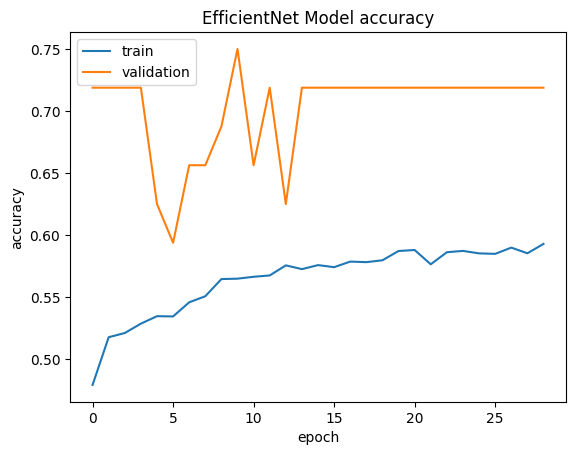

In [57]:
plt.plot(history_efficient.history["accuracy"])
plt.plot(history_efficient.history["val_accuracy"])
plt.title("EfficientNet Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

### **Evaluating the EfficientnetNet Model**


In [58]:
# Calculate the number of steps for the entire test set to be processed
test_steps = test_generator_efficientnet.samples // batch_size

# If the number of samples isn't a multiple of the batch size,
# you have one more batch with the remaining samples
if test_generator_efficientnet.samples % batch_size > 0:
    test_steps += 1

# Evaluating the model on the test set
evaluation_results = new_efficient_model.evaluate(test_generator_efficientnet, steps=test_steps)
print(f"Loss: {evaluation_results[0]}, Accuracy: {evaluation_results[1]}")

4/4 [==============================] - 1s 7ms/step - loss: 0.9258 - accuracy: 0.6328
Loss: 0.9257597923278809, Accuracy: 0.6328125


### **Plotting the confusion matrix**


4/4 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

       happy       0.56      0.78      0.65        32
     neutral       0.50      0.53      0.52        32
         sad       0.74      0.53      0.62        32
    surprise       0.85      0.69      0.76        32

    accuracy                           0.63       128
   macro avg       0.66      0.63      0.64       128
weighted avg       0.66      0.63      0.64       128



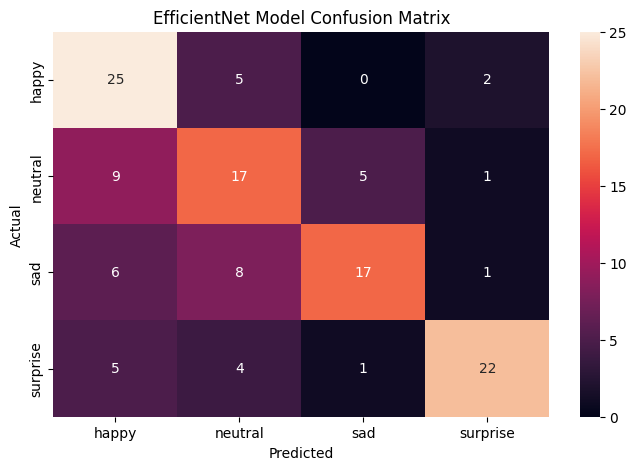

In [59]:
pred_probabilities = new_efficient_model.predict(test_generator_efficientnet, steps=test_steps)
pred = np.argmax(pred_probabilities, axis=1)

# Getting the true labels from the generator
y_true = test_generator_efficientnet.classes

# Printing the classification report with actual emotion labels
print(classification_report(y_true, pred, target_names=CATEGORIES))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt=".0f", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("EfficientNet Model Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

**Observations and Insights:\_\_**

**Note: You can even go back and build your own architecture on top of the VGG16 Transfer layer and see if you can improve the performance.**


**Think About It:**

- What is your overall performance of these Transfer Learning Architectures? Can we draw a comparison of these models' performances. Are we satisfied with the accuracies that we have received?
- Do you think our issue lies with 'rgb' color_mode?


Now that we have tried multiple pre-trained models, let's build a complex CNN architecture and see if we can get better performance.


## **Building a Complex Neural Network Architecture**


In this section, we will build a more complex Convolutional Neural Network Model that has close to as many parameters as we had in our Transfer Learning Models. However, we will have only 1 input channel for our input images.


## **Creating our Data Loaders**

In this section, we are creating data loaders which we will use as inputs to the more Complicated Convolutional Neural Network. We will go ahead with color_mode = 'grayscale'.


In [60]:
# Set this to 'grayscale' as the images are in grayscale
color_mode = "grayscale"
color_layers = 1
# As we have checked, all images are 48x48, we will set the img_width and img_height to 48
img_width, img_height = 48, 48
# A batch size of 32 is appropriate for this dataset provide to provide a good balance
# between the model's ability to generalize (avoid overfitting) and computational efficiency.
batch_size = 32

# Training Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values to [0,1]
    horizontal_flip=True,  # Faces are symmetric; flipping can simulate looking from another direction
    brightness_range=(0.5, 1.5),  # Randomly adjust brightness to simulate different lighting conditions
    shear_range=0.3,  # Shear transformations for perspective changes
    rotation_range=20,  # Slight rotation to introduce variability without distorting emotion features
    width_shift_range=0.1,  # Slight horizontal shifts to simulate off-center faces
    height_shift_range=0.1,  # Slight vertical shifts to account for different heights/angles
    zoom_range=0.1,  # Small zoom in/out to simulate closer or further away faces
)

# Validation and Testing Data should not be augmented!
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Assuming train_dir, validation_dir, and test_dir should follow the structure in DATADIR and SUBDIRS
train_dir = os.path.join(DATADIR, SUBDIRS_DICT["train"])
validation_dir = os.path.join(DATADIR, SUBDIRS_DICT["validation"])
test_dir = os.path.join(DATADIR, SUBDIRS_DICT["test"])

# Train Generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode=color_mode,  # Set to 'grayscale'
    class_mode="categorical",
)

# Validation Generator
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode=color_mode,  # Set to 'grayscale'
    class_mode="categorical",
    shuffle=False,  # shuffle=False to keep data in order for evaluation
)

# Testing Generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode=color_mode,  # Set to 'grayscale'
    class_mode="categorical",
    shuffle=False,  # shuffle=False to keep data in order for testing
)

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


### **Model Building**

- Try building a layer with 5 Convolutional Blocks and see if performance increases.


In [61]:
backend.clear_session()

# Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)

random.seed(42)
tf.random.set_seed(42)

In [62]:
# Initializing a sequential model
model_complex = Sequential()

# First Convolutional Block
model_complex.add(Conv2D(64, kernel_size=2, padding="same", input_shape=(48, 48, 1)))
model_complex.add(BatchNormalization())
model_complex.add(LeakyReLU(alpha=0.1))
model_complex.add(MaxPooling2D(pool_size=2))

# Second Convolutional Block
model_complex.add(Conv2D(128, kernel_size=2, padding="same", input_shape=(48, 48, 1)))
model_complex.add(BatchNormalization())
model_complex.add(LeakyReLU(alpha=0.1))
model_complex.add(MaxPooling2D(pool_size=2))

# Third Convolutional Block
model_complex.add(Conv2D(256, kernel_size=2, padding="same"))
model_complex.add(BatchNormalization())
model_complex.add(LeakyReLU(alpha=0.1))
model_complex.add(MaxPooling2D(pool_size=2))

# Fourth Convolutional Block
model_complex.add(Conv2D(512, kernel_size=2, padding="same"))
model_complex.add(BatchNormalization())
model_complex.add(LeakyReLU(alpha=0.1))
model_complex.add(MaxPooling2D(pool_size=2))

# Fifth Convolutional Block
model_complex.add(Conv2D(128, kernel_size=2, padding="same"))
model_complex.add(BatchNormalization())
model_complex.add(LeakyReLU(alpha=0.1))
model_complex.add(MaxPooling2D(pool_size=2))

# Flatten the output of the conv layers to feed into the dense layers
model_complex.add(Flatten())

model_complex.add(Dense(512, activation="relu"))
model_complex.add(Dense(128, activation="relu"))
model_complex.add(Dense(64))
model_complex.add(BatchNormalization())
model_complex.add(ReLU())  # Using ReLU after batch normalization
model_complex.add(Dense(4, activation="softmax"))

# Using Adam Optimizer
optimizer = Adam(learning_rate=0.001)

### **Compiling and Training the Model**


In [63]:
model_complex.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
model_complex.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        320       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       32896     
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 128)       5

In [64]:
# Get the current time
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")

# Set up Early Stopping with a patience 7 but acting after at least 30 epochs
delayed_early_stopping = DelayedEarlyStopping(
    monitor="val_loss", patience=7, verbose=1, restore_best_weights=True, start_epoch=30
)

# Define the learning rate scheduler callback
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=0.00001, verbose=1)

mc = ModelCheckpoint(
    f"{results_path}/best_model_complex_{current_time}.keras",
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    save_best_only=True,
)

# Pulling a single large batch of random validation data for doing the validation after each epoch
validationX, validationY = validation_generator.next()

# Fitting the model with 45 epochs and using validation set
history_complex = model_complex.fit(
    train_generator,
    epochs=45,
    validation_data=(validationX, validationY),
    callbacks=[reduce_lr, mc, delayed_early_stopping],
)

Epoch 1/45
473/473 [==============================] - 10s 14ms/step - loss: 1.2308 - accuracy: 0.4156 - val_loss: 2.0396 - val_accuracy: 0.0625 - lr: 0.0010
Epoch 2/45
473/473 [==============================] - 6s 12ms/step - loss: 0.9969 - accuracy: 0.5693 - val_loss: 0.6881 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 3/45
473/473 [==============================] - 6s 12ms/step - loss: 0.8950 - accuracy: 0.6239 - val_loss: 1.2413 - val_accuracy: 0.6562 - lr: 0.0010
Epoch 4/45
473/473 [==============================] - 6s 12ms/step - loss: 0.8563 - accuracy: 0.6410 - val_loss: 0.4769 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 5/45
473/473 [==============================] - 6s 12ms/step - loss: 0.8267 - accuracy: 0.6570 - val_loss: 0.6167 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 6/45
473/473 [==============================] - 6s 12ms/step - loss: 0.8046 - accuracy: 0.6666 - val_loss: 0.7570 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 7/45
473/473 [==============================] - 6s 12ms/s

### **Plotting the Training and Validation Accuracies**


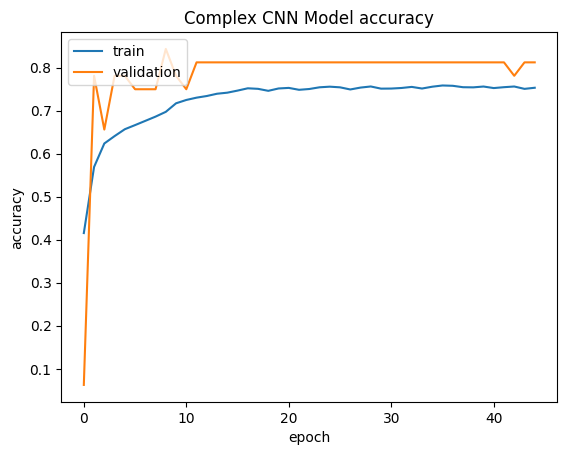

In [65]:
plt.plot(history_complex.history["accuracy"])
plt.plot(history_complex.history["val_accuracy"])
plt.title("Complex CNN Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

### **Evaluating the Model on Test Set**


In [66]:
# Calculate the number of steps for the entire test set to be processed
test_steps = test_generator.samples // batch_size

# If the number of samples isn't a multiple of the batch size,
# you have one more batch with the remaining samples
if test_generator.samples % batch_size > 0:
    test_steps += 1

# Evaluating the model on the test set
evaluation_results = model_complex.evaluate(test_generator, steps=test_steps)
print(f"Loss: {evaluation_results[0]}, Accuracy: {evaluation_results[1]}")

4/4 [==============================] - 0s 5ms/step - loss: 0.5429 - accuracy: 0.8125
Loss: 0.5428584814071655, Accuracy: 0.8125


### **Plotting Confusion Matrix**


4/4 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

       happy       0.93      0.81      0.87        32
     neutral       0.72      0.81      0.76        32
         sad       0.74      0.72      0.73        32
    surprise       0.88      0.91      0.89        32

    accuracy                           0.81       128
   macro avg       0.82      0.81      0.81       128
weighted avg       0.82      0.81      0.81       128



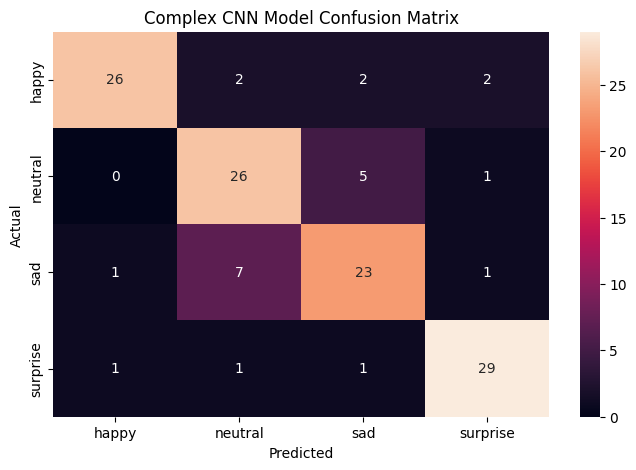

In [67]:
pred_probabilities = model_complex.predict(test_generator, steps=test_steps)
pred = np.argmax(pred_probabilities, axis=1)

# Getting the true labels from the generator
y_true = test_generator.classes

# Printing the classification report with actual emotion labels
print(classification_report(y_true, pred, target_names=CATEGORIES))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt=".0f", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("Complex CNN Model Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

**Observations and Insights:\_\_**


### **Plotting the Confusion Matrix for the chosen final model**


4/4 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

       happy       0.93      0.81      0.87        32
     neutral       0.72      0.81      0.76        32
         sad       0.74      0.72      0.73        32
    surprise       0.88      0.91      0.89        32

    accuracy                           0.81       128
   macro avg       0.82      0.81      0.81       128
weighted avg       0.82      0.81      0.81       128



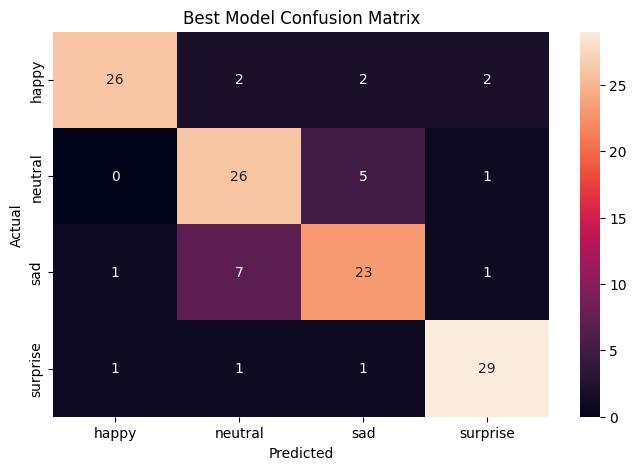

In [68]:
pred_probabilities = model_complex.predict(test_generator, steps=test_steps)
pred = np.argmax(pred_probabilities, axis=1)

# Getting the true labels from the generator
y_true = test_generator.classes

# Printing the classification report with actual emotion labels
print(classification_report(y_true, pred, target_names=CATEGORIES))

# Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true, pred)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt=".0f", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.title("Best Model Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

**Observations and Insights:\_\_**


## **Conclusion:\*\***\_\_\_\_**\*\***


### **Insights**

### **Refined insights**:

- What are the most meaningful insights from the data relevant to the problem?

### **Comparison of various techniques and their relative performance**:

- How do different techniques perform? Which one is performing relatively better? Is there scope to improve the performance further?

### **Proposal for the final solution design**:

- What model do you propose to be adopted? Why is this the best solution to adopt?
